# Bike Flow Data Analysis

This Jupyter notebook aggregates several Python scripts for analyzing a bike-sharing dataset. 
The analysis focuses on different aspects such as time, gender, user type, and station activity patterns. 
Each section represents a distinct analysis originally in separate Python scripts. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'past_data2.csv'  # Replace with the actual file path
bike_data = pd.read_csv(file_path)
bike_data

,Unnamed: 0,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender
0,0,131,2018-05-01 07:29:57.549,2018-05-01 07:32:08.616,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,29617,Subscriber,1966.0,1
1,1,73,2018-05-01 08:13:58.256,2018-05-01 08:15:11.923,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,29288,Subscriber,1975.0,1
2,2,4929,2018-05-01 08:17:21.311,2018-05-01 09:39:31.077,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,29520,Customer,1969.0,0
3,3,432,2018-05-01 08:25:58.715,2018-05-01 08:33:10.896,3183,Exchange Place,40.716247,-74.033459,3202,Newport PATH,40.727224,-74.033759,29595,Subscriber,1973.0,1
4,4,432,2018-05-01 08:28:09.916,2018-05-01 08:35:22.144,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,-74.035483,33623,Subscriber,1959.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301346,1301346,621,2019-09-30 23:11:40.063,2019-09-30 23:22:01.837,3194,McGinley Square,40.725340,-74.067622,3191,Union St,40.718211,-74.083639,26245,Subscriber,1962.0,1
1301347,1301347,167,2019-09-30 23:19:02.938,2019-09-30 23:21:50.829,3211,Newark Ave,40.721525,-74.046305,3209,Brunswick St,40.724176,-74.050656,29525,Subscriber,1984.0,1
1301348,1301348,94,2019-09-30 23:26:24.747,2019-09-30 23:27:59.231,3213,Van Vorst Park,40.718489,-74.047727,3483,Montgomery St,40.719420,-74.050990,26317,Subscriber,1958.0,1
1301349,1301349,366,2019-09-30 23:49:00.426,2019-09-30 23:55:06.962,3638,Washington St,40.724294,-74.035483,3270,Jersey & 6th St,40.725289,-74.045572,29488,Subscriber,1976.0,1


## All Time Analysis

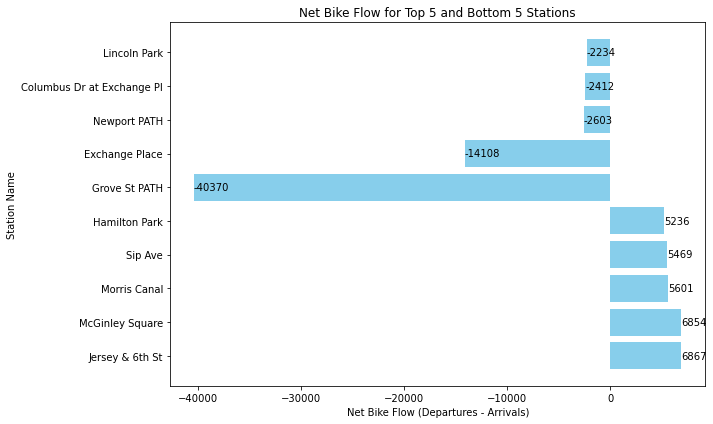

In [2]:
# Calculating net bike flow (departures - arrivals) for each station
departures = bike_data['startstationid'].value_counts()
arrivals = bike_data['endstationid'].value_counts()
net_flow = departures.subtract(arrivals, fill_value=0)

# Sorting and selecting the top 5 and bottom 5 stations
top_5_stations = net_flow.sort_values(ascending=False).head(5)
bottom_5_stations = net_flow.sort_values().head(5)
stations_to_visualize = pd.concat([top_5_stations, bottom_5_stations])

# Getting station names
station_names = bike_data[['startstationid', 'startstationname']].drop_duplicates().set_index('startstationid')
stations_to_visualize = stations_to_visualize.to_frame('net_flow').join(station_names, how='left')

# Resetting index for visualization
stations_to_visualize.reset_index(inplace=True)
stations_to_visualize.rename(columns={'index': 'stationid'}, inplace=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(stations_to_visualize['startstationname'], stations_to_visualize['net_flow'], color='skyblue')
plt.xlabel('Net Bike Flow (Departures - Arrivals)')
plt.ylabel('Station Name')
plt.title('Net Bike Flow for Top 5 and Bottom 5 Stations')

# Adding values on the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width - 35
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.tight_layout()
plt.show()


## Day of Week Analysis

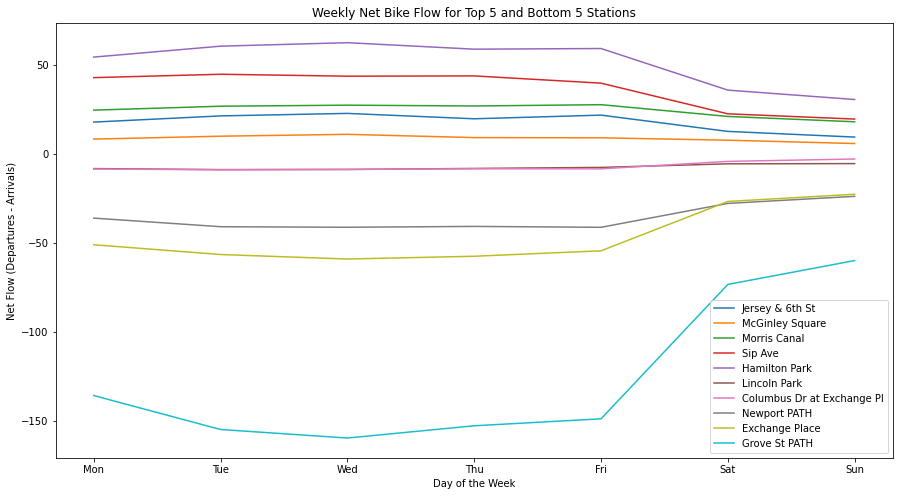

In [3]:

# Preprocessing for the plot
bike_data['starttime'] = pd.to_datetime(bike_data['starttime'])
bike_data['day_of_week'] = bike_data['starttime'].dt.dayofweek  # Monday=0, Sunday=6
bike_data['year_month_week'] = bike_data['starttime'].dt.to_period('W')

num_weeks = (max(bike_data['year_month_week']) - min(bike_data['year_month_week'])).n
net_flow = pd.merge(bike_data['startstationname'].value_counts().rename_axis('stationname').reset_index(name='departures'), 
                    bike_data['endstationname'].value_counts().rename_axis('stationname').reset_index(name='arrivals'), 
                    on='stationname', how='outer').fillna(0)

net_flow['net_flow'] = net_flow['departures'] - net_flow['arrivals']
net_flow_sorted = net_flow.sort_values(by='net_flow', ascending=False).reset_index(drop=True)

top_5_stations = net_flow_sorted.head(5)['stationname']
bottom_5_stations = net_flow_sorted.tail(5)['stationname']
top_bottom_stations_data = bike_data[bike_data['startstationname'].isin(top_5_stations) | bike_data['endstationname'].isin(bottom_5_stations)]

weekly_net_flow = top_bottom_stations_data.groupby(['day_of_week', 'startstationname']).size().reset_index(name='departures')
weekly_net_flow = weekly_net_flow.merge(top_bottom_stations_data.groupby(['day_of_week', 'endstationname']).size().reset_index(name='arrivals'), 
                                        left_on=['day_of_week', 'startstationname'], right_on=['day_of_week', 'endstationname'], how='outer').fillna(0)
weekly_net_flow['net_flow'] = (weekly_net_flow['departures'] - weekly_net_flow['arrivals']) / num_weeks
weekly_net_flow['stationname'] = weekly_net_flow.apply(lambda row: row['startstationname'] if not pd.isna(row['startstationname']) else row['endstationname'], axis=1)
weekly_net_flow = weekly_net_flow[['day_of_week', 'stationname', 'net_flow']]

plt.figure(figsize=(15, 8))
for station in top_5_stations.append(bottom_5_stations):
    station_data = weekly_net_flow[weekly_net_flow['stationname'] == station]
    plt.plot('day_of_week', 'net_flow', data=station_data, label=station)

plt.title('Weekly Net Bike Flow for Top 5 and Bottom 5 Stations')
plt.xlabel('Day of the Week')
plt.ylabel('Net Flow (Departures - Arrivals)')
plt.legend()
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show()

## Gender Analysis

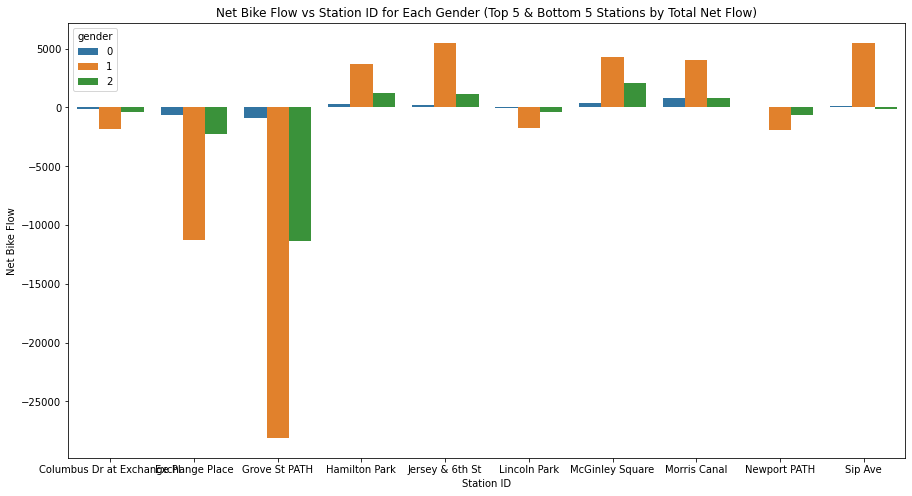

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating net flow for each station and gender
net_flow_gender = bike_data.groupby(['startstationname', 'gender']).size().reset_index(name='departures')
net_flow_gender = net_flow_gender.merge(bike_data.groupby(['endstationname', 'gender']).size().reset_index(name='arrivals'), left_on=['startstationname', 'gender'], right_on=['endstationname', 'gender'], how='outer')
net_flow_gender.fillna(0, inplace=True)
net_flow_gender['net_flow'] = net_flow_gender['departures'] - net_flow_gender['arrivals']
net_flow_gender.rename(columns={'startstationname': 'stationname'}, inplace=True)
net_flow_gender.drop(['endstationname'], axis=1, inplace=True)

# Calculating total net flow for each station (regardless of gender)
total_net_flow_gender = net_flow_gender.groupby('stationname')['net_flow'].sum().reset_index()

# Identifying the top 5 and bottom 5 stations based on total net flow
top_5_total_gender = total_net_flow_gender.nlargest(5, 'net_flow')
bottom_5_total_gender = total_net_flow_gender.nsmallest(5, 'net_flow')

# Filtering the original net flow data for these stations
selected_stations_gender = pd.concat([top_5_total_gender, bottom_5_total_gender])
filtered_net_flow_gender = net_flow_gender[net_flow_gender['stationname'].isin(selected_stations_gender['stationname'])]

# Visualizing the net flow vs station ID for each gender for the selected stations
plt.figure(figsize=(15, 8))
sns.barplot(x='stationname', y='net_flow', hue='gender', data=filtered_net_flow_gender)
plt.title('Net Bike Flow vs Station ID for Each Gender (Top 5 & Bottom 5 Stations by Total Net Flow)')
plt.xlabel('Station ID')
plt.ylabel('Net Bike Flow')
plt.show()


## Hour of Day Analysis

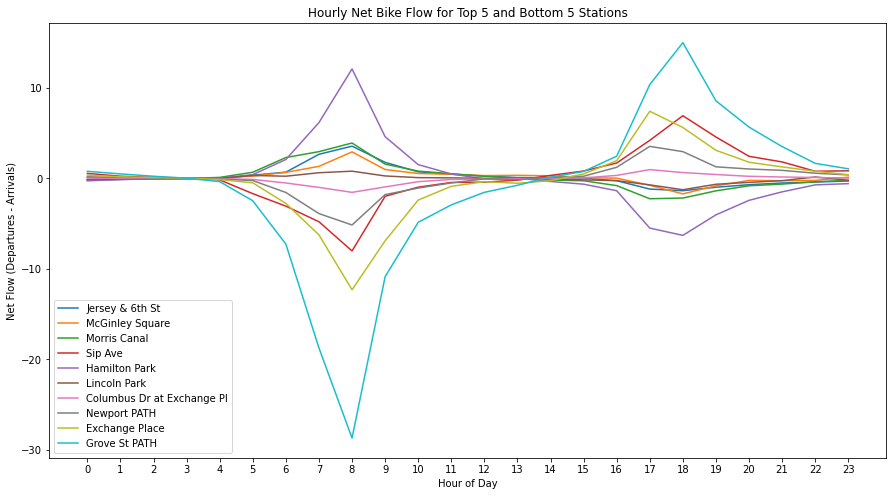

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

bike_data['year_month_week'] = bike_data['starttime'].dt.to_period('D')
num_days = (max(bike_data['year_month_week']) - min(bike_data['year_month_week'])).n
bike_data['hour'] = bike_data['starttime'].dt.hour
net_flow = pd.merge(bike_data['startstationname'].value_counts().rename_axis('stationname').reset_index(name='departures'), 
                    bike_data['endstationname'].value_counts().rename_axis('stationname').reset_index(name='arrivals'), 
                    on='stationname', how='outer').fillna(0)
net_flow['net_flow'] = net_flow['departures'] - net_flow['arrivals']
net_flow_sorted = net_flow.sort_values(by='net_flow', ascending=False).reset_index(drop=True)

top_5_stations = net_flow_sorted.head(5)['stationname']
bottom_5_stations = net_flow_sorted.tail(5)['stationname']
hourly_net_flow = bike_data.groupby(['hour', 'startstationname']).size().reset_index(name='departures')
hourly_net_flow = hourly_net_flow.merge(bike_data.groupby(['hour', 'endstationname']).size().reset_index(name='arrivals'), 
                                        left_on=['hour', 'startstationname'], right_on=['hour', 'endstationname'], how='outer').fillna(0)
hourly_net_flow['net_flow'] = (hourly_net_flow['departures'] - hourly_net_flow['arrivals']) / num_days
hourly_net_flow['stationname'] = hourly_net_flow.apply(lambda row: row['startstationname'] if not pd.isna(row['startstationname']) else row['endstationname'], axis=1)
hourly_net_flow = hourly_net_flow[['hour', 'stationname', 'net_flow']]

plt.figure(figsize=(15, 8))
for station in top_5_stations.append(bottom_5_stations):
    station_data = hourly_net_flow[hourly_net_flow['stationname'] == station]
    plt.plot('hour', 'net_flow', data=station_data, label=station)

plt.title('Hourly Net Bike Flow for Top 5 and Bottom 5 Stations')
plt.xlabel('Hour of Day')
plt.ylabel('Net Flow (Departures - Arrivals)')
plt.legend()
plt.xticks(range(0, 24), range(0, 24))
plt.show()

## Monthly Analysis

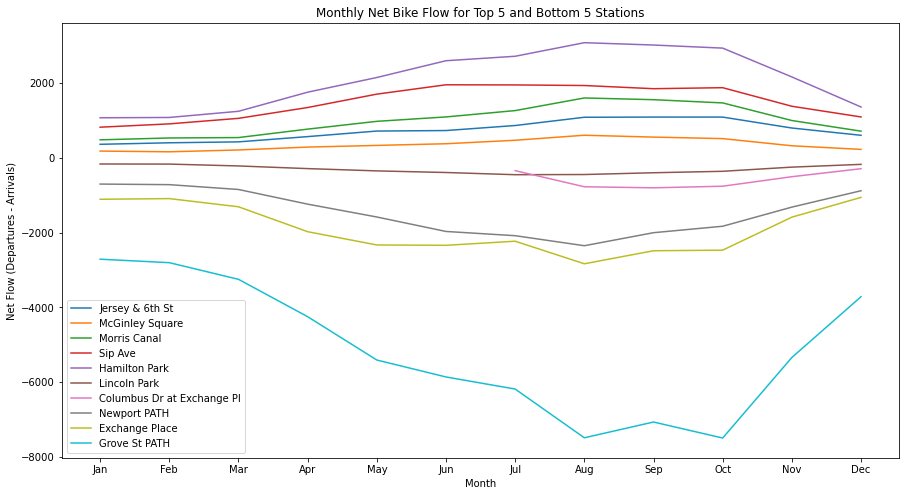

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing for the plot

bike_data['month'] = bike_data['starttime'].dt.month
bike_data['year'] = bike_data['starttime'].dt.to_period('Y')
num_years = (max(bike_data['year']) - min(bike_data['year'])).n
net_flow = pd.merge(bike_data['startstationname'].value_counts().rename_axis('stationname').reset_index(name='departures'), 
                    bike_data['endstationname'].value_counts().rename_axis('stationname').reset_index(name='arrivals'), 
                    on='stationname', how='outer').fillna(0)
net_flow['net_flow'] = net_flow['departures'] - net_flow['arrivals']
net_flow_sorted = net_flow.sort_values(by='net_flow', ascending=False).reset_index(drop=True)

top_5_stations = net_flow_sorted.head(5)['stationname']
bottom_5_stations = net_flow_sorted.tail(5)['stationname']
top_bottom_stations_data = bike_data[bike_data['startstationname'].isin(top_5_stations) | bike_data['endstationname'].isin(bottom_5_stations)]
monthly_net_flow = top_bottom_stations_data.groupby(['month', 'startstationname']).size().reset_index(name='departures')
monthly_net_flow = monthly_net_flow.merge(top_bottom_stations_data.groupby(['month', 'endstationname']).size().reset_index(name='arrivals'), 
                                          left_on=['month', 'startstationname'], right_on=['month', 'endstationname'], how='outer').fillna(0)
monthly_net_flow['net_flow'] = (monthly_net_flow['departures'] - monthly_net_flow['arrivals']) / num_years
monthly_net_flow['stationname'] = monthly_net_flow.apply(lambda row: row['startstationname'] if not pd.isna(row['startstationname']) else row['endstationname'], axis=1)
monthly_net_flow = monthly_net_flow[['month', 'stationname', 'net_flow']]

# Plotting
plt.figure(figsize=(15, 8))
for station in top_5_stations.append(bottom_5_stations):
    station_data = monthly_net_flow[monthly_net_flow['stationname'] == station]
    plt.plot('month', 'net_flow', data=station_data, label=station)

plt.title('Monthly Net Bike Flow for Top 5 and Bottom 5 Stations')
plt.xlabel('Month')
plt.ylabel('Net Flow (Departures - Arrivals)')
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## User Type Analysis

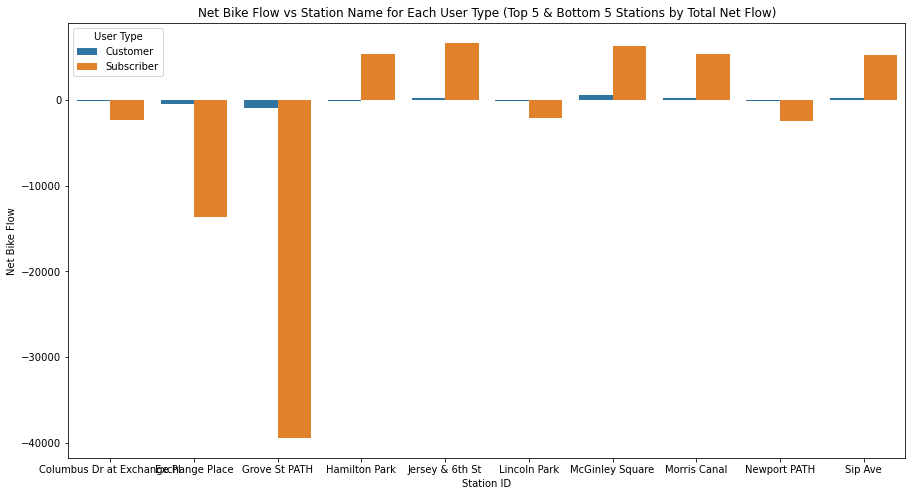

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating net flow for each station and user type
net_flow_user = bike_data.groupby(['startstationname', 'usertype']).size().reset_index(name='departures')
net_flow_user = net_flow_user.merge(bike_data.groupby(['endstationname', 'usertype']).size().reset_index(name='arrivals'), left_on=['startstationname', 'usertype'], right_on=['endstationname', 'usertype'], how='outer')
net_flow_user.fillna(0, inplace=True)
net_flow_user['net_flow'] = net_flow_user['departures'] - net_flow_user['arrivals']
net_flow_user.rename(columns={'startstationname': 'stationname'}, inplace=True)


# Calculating total net flow for each station (regardless of user type)
total_net_flow = net_flow_user.groupby('stationname')['net_flow'].sum().reset_index()

# Identifying the top 5 and bottom 5 stations based on total net flow
top_5_total = total_net_flow.nlargest(5, 'net_flow')
bottom_5_total = total_net_flow.nsmallest(5, 'net_flow')

# Filtering the original net flow data for these stations
selected_stations = pd.concat([top_5_total, bottom_5_total])
filtered_net_flow = net_flow_user[net_flow_user['stationname'].isin(selected_stations['stationname'])]

# Visualizing the net flow vs station ID for each user type for the selected stations
plt.figure(figsize=(15, 8))
sns.barplot(x='stationname', y='net_flow', hue='usertype', data=filtered_net_flow)
plt.title('Net Bike Flow vs Station Name for Each User Type (Top 5 & Bottom 5 Stations by Total Net Flow)')
plt.xlabel('Station ID')
plt.ylabel('Net Bike Flow')
plt.legend(title='User Type')
plt.show()